# Installing Libraries

In [0]:
!pip install paho-mqtt
!pip install catboost

# Importing Libraries

In [0]:
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,LabelBinarizer,OneHotEncoder,StandardScaler,OrdinalEncoder
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV , cross_val_score
from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,roc_curve,classification_report
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
from catboost import Pool, CatBoostClassifier, cv
import paho.mqtt.client as mqtt
import json
import csv
import os
import ast

# Create Required Functions and Pipeline

In [0]:
def save(predictions,src,dest):
  submission = pd.read_csv('%s.csv'%src)
  submission.loc[:,'Predicted_ID'] = np.uint8(predictions)
  submission.to_csv("%s.csv"%dest,index=False)

def save_all(res,src):
  submission = pd.read_csv('%s.csv'%src)
  for key,val in res.items():
    submission.loc[:,'Predicted_ID_%s'%key] = np.uint8(val)
    submission.to_csv("Final_results.csv",index=False)
  
def read_dataset(path):
    return pd.read_csv(path)

class DataFrameSelector (BaseEstimator, TransformerMixin):
    def __init__ (self,attribute_names):
        self.attribute_names = attribute_names
    def fit(self,X,y = None):
        return self
    def transform(self,X,y = None):
        return X[self.attribute_names].values
    
class LabelBinarizerPipeline(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, X, y=None):
        self.encoder.fit(X)
        return self
    def transform(self, X, y=None):
        return self.encoder.transform(X)

# Functions for Real Time Data capturing and sending

In [0]:
sub_topic = "to_model"
pub_topic = "from_model"
pub_data = 'data'

data_point = [[]]
def on_connect(client, userdata, flags, rc):
    if (rc==0):
        print ("Connection Successfull!")
        client.subscribe(sub_topic)
        print ("Subscribe to '%s'"%sub_topic)
    else:
        print("Connected with result code "+str(rc))

        
def on_message(client, userdata, msg):
    global data_point
    data_point,dataset = get_data_point(msg.payload)
    print(data_point)
    #Prediction using Random Forest
    res = int(rfc.predict(data_point)[0])
    print("Predicted Result: ",res)
    client.publish(pub_topic,str(res))
    client.publish(pub_data,dataset)

def get_data_point(data1):
    d_point = [[]]
    result = {'f0:ec:af:cf:6c:e1':-200, 'c2:b6:6e:70:fa:f7':-200,
       'd9:5f:f5:4f:10:89':-200, 'c4:52:32:5c:31:e7':-200, 'e9:3c:4a:34:13:fb':-200,
       'ed:61:e4:e8:22:30':-200, 'ea:01:26:75:a4:c3':-200, 'd0:4e:10:2e:cb:84':-200,
       'e4:e0:0a:ae:fd:e2':-200, 'fa:35:76:56:6f:e3':-200, 'd5:b7:dc:69:ca:ae':-200,
       'ca:81:7a:d7:55:49':-200, 'e7:2b:ea:2f:95:c5':-200, 'd4:32:fc:b5:f0:b5':-200}
    try:
        data = ast.literal_eval(data1.decode("utf-8"))
        #print(data)
        for key,value in data.items():
            if (value==-200):
                result[key] = "Not in Range"
            elif key in result and result[key] == -200:
                result[key] = float(value)
        #print(result)

        for key,value in result.items():
            if (value=="Not in Range"):
                d_point[0].append(-200)
            else:
                d_point[0].append(value)
        return d_point, json.dumps(result)
        
    except Exception as e:
        print(e)

# Inspecting Dataset

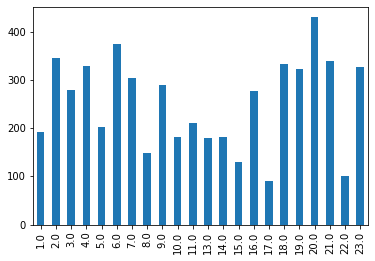

In [26]:
df_train = read_dataset('/content/ble_data.csv')
df_train.id.value_counts().sort_index(ascending=True).plot(kind='bar')
res = {}

In [27]:
df_train.head(10)

,id,f0:ec:af:cf:6c:e1,c9:a6:4d:9b:c0:8c,c2:b6:6e:70:fa:f7,d9:5f:f5:4f:10:89,c4:52:32:5c:31:e7,e9:3c:4a:34:13:fb,ed:61:e4:e8:22:30,ea:01:26:75:a4:c3,d0:4e:10:2e:cb:84,e4:e0:0a:ae:fd:e2,fa:35:76:56:6f:e3,d5:b7:dc:69:ca:ae,ca:81:7a:d7:55:49,e7:2b:ea:2f:95:c5,d4:32:fc:b5:f0:b5
0,21.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0
1,2.0,-200.0,-200.0,-200.0,-86.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0
2,7.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0
3,19.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-86.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-88.0
4,18.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-84.0,-74.0,-200.0
5,20.0,-200.0,-200.0,-87.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0
6,4.0,-200.0,-200.0,-200.0,-85.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-91.0,-200.0,-200.0,-200.0
7,20.0,-200.0,-200.0,-87.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0
8,21.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-72.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0
9,10.0,-77.0,-200.0,-200.0,-200.0,-200.0,-84.0,-88.0,-96.0,-85.0,-85.0,-200.0,-200.0,-90.0,-200.0,-200.0


In [28]:
df_train.columns

Index(['id', 'f0:ec:af:cf:6c:e1', 'c9:a6:4d:9b:c0:8c', 'c2:b6:6e:70:fa:f7',
       'd9:5f:f5:4f:10:89', 'c4:52:32:5c:31:e7', 'e9:3c:4a:34:13:fb',
       'ed:61:e4:e8:22:30', 'ea:01:26:75:a4:c3', 'd0:4e:10:2e:cb:84',
       'e4:e0:0a:ae:fd:e2', 'fa:35:76:56:6f:e3', 'd5:b7:dc:69:ca:ae',
       'ca:81:7a:d7:55:49', 'e7:2b:ea:2f:95:c5', 'd4:32:fc:b5:f0:b5'],
      dtype='object')

# Data preprocessing and Splitiing

In [0]:
df_train = df_train.drop(['c9:a6:4d:9b:c0:8c'],axis = 1)
X = df_train.iloc[:,1:].values
y = df_train.iloc[:,0].values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state = 42)

In [0]:
test_set = pd.DataFrame(X_test,columns = ['f0:ec:af:cf:6c:e1', 'c2:b6:6e:70:fa:f7', 'd9:5f:f5:4f:10:89',
       'c4:52:32:5c:31:e7', 'e9:3c:4a:34:13:fb', 'ed:61:e4:e8:22:30',
       'ea:01:26:75:a4:c3', 'd0:4e:10:2e:cb:84', 'e4:e0:0a:ae:fd:e2',
       'fa:35:76:56:6f:e3', 'd5:b7:dc:69:ca:ae', 'ca:81:7a:d7:55:49',
       'e7:2b:ea:2f:95:c5', 'd4:32:fc:b5:f0:b5'])

test_set['True_ID'] = np.uint8(y_test)
test_set.to_csv('Test.csv',index=False)

# Getting Predictions

Random Forest Classifier

In [31]:
start = time.time()
rfc = RandomForestClassifier(max_depth=10,random_state=0)
rfc.fit(X_train,y_train)
end = time.time()
s = time.time()
y_pred_rfc = rfc.predict(X_test)
e = time.time()
acc_rfc = accuracy_score(y_test,y_pred_rfc)
rfct = end-start
rfctest = (e-s)/len(X_test)
acc_rfc

0.8584229390681004

In [0]:
acc_rfc = accuracy_score(y_test, y_pred_rfc)
prec_rfc = precision_score(y_test, y_pred_rfc,average='weighted')
rec_rfc = recall_score(y_test, y_pred_rfc,average='weighted')
f1_rfc = f1_score(y_test, y_pred_rfc,average='weighted')
res['RFC'] = y_pred_rfc
save(y_pred_rfc,'Test','RFC')

Support Vector Machine

In [32]:
start = time.time()
svm = SVC(kernel='linear',C = 1.2)
svm.fit(X_train,y_train)
end = time.time()
s = time.time()
y_pred_svc = svm.predict(X_test)
e = time.time()
acc_svc = accuracy_score(y_test,y_pred_svc)
svmlt = end-start
svmltest = (e-s)/len(X_test)
acc_svc

0.7688172043010753

In [0]:
acc_svc = accuracy_score(y_test, y_pred_svc)
prec_svc = precision_score(y_test, y_pred_svc,average='weighted')
rec_svc = recall_score(y_test, y_pred_svc,average='weighted')
f1_svc = f1_score(y_test, y_pred_svc,average='weighted')
res['SVC_Lin'] = y_pred_svc
save(y_pred_svc,'Test','SVM_LIn')

In [33]:
start = time.time()
svmrbf = SVC(kernel='rbf')
svmrbf.fit(X_train,y_train)
end = time.time()
s = time.time()
y_pred_svcrbf = svmrbf.predict(X_test)
e = time.time()
acc_svcrbf = accuracy_score(y_test,y_pred_svcrbf)
svmrt = end-start
svmrtest = (e-s)/len(X_test)
acc_svcrbf

0.7293906810035843

In [0]:
acc_svcrbf = accuracy_score(y_test, y_pred_svcrbf)
prec_svcrbf = precision_score(y_test, y_pred_svcrbf,average='weighted')
rec_svcrbf = recall_score(y_test, y_pred_svcrbf,average='weighted')
f1_svcrbf = f1_score(y_test, y_pred_svcrbf,average='weighted')
res['SVC_Rbf'] = y_pred_svcrbf
save(y_pred_svc,'Test','SVM_Rbf')

CAT Boost

In [0]:
start = time.time()
model_cat = CatBoostClassifier(eval_metric='Accuracy',colsample_bylevel=0.4,max_depth=7,n_estimators=700,
                               learning_rate=0.01,use_best_model=True,random_seed=42)
model_cat.fit(X_train,y_train,eval_set=(X_test,y_test))
end = time.time()
catt = end-start


In [0]:
s = time.time()
y_pred_cat = model_cat.predict(X_test)
e = time.time()
cattest = (e-s)/len(X_test)

In [0]:
acc_cat = accuracy_score(y_test, y_pred_cat)
prec_cat = precision_score(y_test, y_pred_cat,average='weighted')
rec_cat = recall_score(y_test, y_pred_cat,average='weighted')
f1_cat = f1_score(y_test, y_pred_cat,average='weighted')
res['CAT'] = y_pred_cat
save(y_pred_cat,'Test','CAT')

In [35]:
NUM_CLASSES = 23
start = time.time()
knn = KNeighborsClassifier(n_neighbors=NUM_CLASSES)
knn.fit(X_train,y_train)
end = time.time()
s = time.time()
y_pred_knn = knn.predict(X_test)
e = time.time()
acc_knn = accuracy_score(y_test,y_pred_knn)
knnt = end-start
knntest = (e-s)/len(X_test)
acc_knn

0.7939068100358423

In [0]:
acc_knn = accuracy_score(y_test, y_pred_knn)
prec_knn = precision_score(y_test, y_pred_knn,average='weighted')
rec_knn = recall_score(y_test, y_pred_knn,average='weighted')
f1_knn = f1_score(y_test, y_pred_knn,average='weighted')
res['KNN'] = y_pred_knn
save(y_pred_cat,'Test','KNN')

Printing Results

In [40]:
save_all(res,'Test')
results = pd.DataFrame([ 
                        ['Random Forest', acc_rfc,prec_rfc,rec_rfc, f1_rfc],
                        ['CATBoost (700 estimators)', acc_cat,prec_cat,rec_cat, f1_cat],
                        ['KNN', acc_knn,prec_knn,rec_knn, f1_knn],
                        ['SVM-Linear', acc_svc,prec_svc,rec_svc, f1_svc],
                        ['SVM-Rbf', acc_svcrbf,prec_svcrbf,rec_svcrbf, f1_svcrbf]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.858423,0.877330,0.858423,0.853298
1,CATBoost (700 estimators),0.856631,0.868892,0.856631,0.852146
2,KNN,0.793907,0.795416,0.793907,0.786101
3,SVM-Linear,0.768817,0.783527,0.768817,0.754927
4,SVM-Rbf,0.729391,0.776605,0.729391,0.714782


In [38]:
timing = pd.DataFrame([ 
                        ['Random Forest', rfct,rfctest*10**6],
                        ['CATBoost (700 estimators)', catt,cattest*10**6],
                        ['KNN', knnt,knntest*10**6],
                        ['SVM-Linear', svmlt,svmltest*10**6],
                        ['SVM-Rbf', svmrt,svmrtest*10**6]],
               columns = ['Model', 'Time taken for training(s)','Inferencing time for sample(us)'])

timing

,Model,Time taken for training(s),Inferencing time for sample(us)
0,Random Forest,0.408128,46.665096
1,CATBoost (700 estimators),19.261410,29.982205
2,KNN,0.031832,68.679933
3,SVM-Linear,58.430970,91.465143
4,SVM-Rbf,0.325068,186.289938


In [76]:
print ('========== Classification Report of Highest Acc. Model ==========')
print(classification_report(y_test,y_pred_rfc))

========== Classification Report of Highest Acc. Model ==========
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        22
         2.0       0.70      0.98      0.82        41
         3.0       0.91      0.36      0.51        28
         4.0       0.86      1.00      0.92        42
         5.0       0.66      1.00      0.79        19
         6.0       0.78      0.82      0.80        39
         7.0       0.95      0.60      0.73        30
         8.0       0.93      1.00      0.97        14
         9.0       0.97      1.00      0.98        32
        10.0       1.00      0.94      0.97        16
        11.0       0.93      1.00      0.96        13
        13.0       1.00      0.78      0.88         9
        14.0       0.80      0.94      0.86        17
        15.0       0.91      0.67      0.77        15
        16.0       0.96      1.00      0.98        27
        17.0       1.00      0.83      0.91         6
        18.0   

# Publish predicted results to display

In [0]:
client = mqtt.Client()
client.on_connect = on_connect
client.on_message = on_message

client.connect("mqtt.eclipse.org", 1883, 60)
client.loop_forever()